## Creating toy multi class dataset.

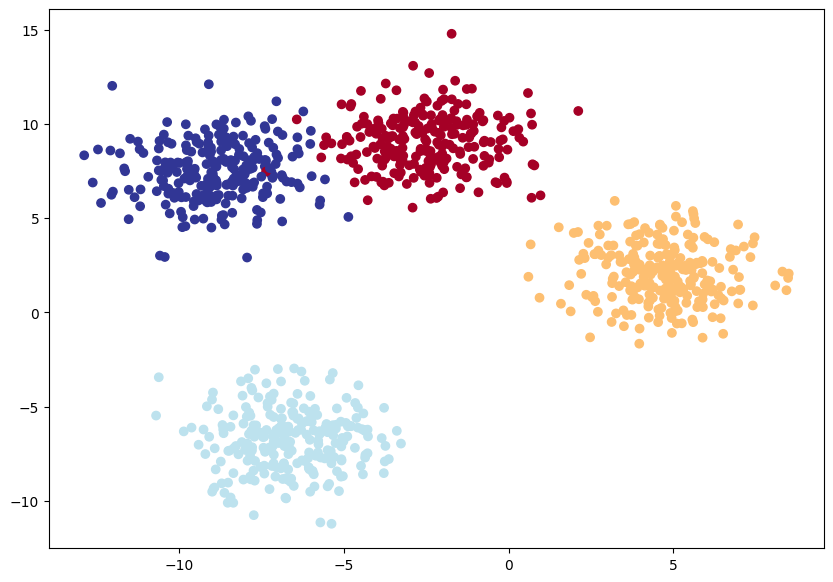

In [ ]:
# Import dependencies.
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation.
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multiclass data.
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features= NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,  # Give the clusters shake up.
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors.
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split the data into train and test.
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot the data.
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);


Dataset is ready.

## Building a multiclass classification model with PyTorch.

In [ ]:
# Create device agnostic code.
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Build multiclass classification model.
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):

    """Initializes multiclass classification model.
    Args:
      input_features (int): Number of input features.
      output_features (int): Number of output features.
      hidden_units (int): Number of hidden units between layers.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(), # For non linearity.
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device.
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Create loss function and an optimizer.

In [ ]:
# Create a loss function.
loss_fn = nn.CrossEntropyLoss()

# Create an Optimizer.
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### Getting prediction probabilites.

In order to evaluate and train and test our model, we need to convert our model's outputs(logit) to prediction probabilities then to prediction labels.

`LOGITS -> PRED_PROBS -> PRED_LABELS`

In [ ]:
# Raw output(logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

These are raw outputs.

### Converting logits to pred_probs

In [ ]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


### Converting pred_probs to pred_prob_labels.

In [ ]:
y_pred_probs[0]

tensor([0.3169, 0.3244, 0.1405, 0.2182])

In [ ]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [ ]:
y_blob_test[:20]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3])

## Building training loop.

In [ ]:
# Calculate accuracy realtime.
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:
# Fit the multicalss model to dataset.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 100

# Put the data into target device.
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Build training loop.
for epoch in range(epochs):
  ### Training.
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

# Print what's happening.
  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:0.4f} | Accuracy: {acc:0.2f}% | Test Loss: {test_loss: 0.4f} | Test Accuracy: {test_acc:0.2}%")

Epoch: 0 | Loss: 0.0331 | Accuracy: 99.25% | Test Loss:  0.0243 | Test Accuracy: 1e+02%
Epoch: 10 | Loss: 0.0316 | Accuracy: 99.25% | Test Loss:  0.0226 | Test Accuracy: 1e+02%
Epoch: 20 | Loss: 0.0304 | Accuracy: 99.25% | Test Loss:  0.0213 | Test Accuracy: 1e+02%
Epoch: 30 | Loss: 0.0296 | Accuracy: 99.25% | Test Loss:  0.0202 | Test Accuracy: 1e+02%
Epoch: 40 | Loss: 0.0289 | Accuracy: 99.25% | Test Loss:  0.0194 | Test Accuracy: 1e+02%
Epoch: 50 | Loss: 0.0283 | Accuracy: 99.25% | Test Loss:  0.0187 | Test Accuracy: 1e+02%
Epoch: 60 | Loss: 0.0279 | Accuracy: 99.25% | Test Loss:  0.0182 | Test Accuracy: 1e+02%
Epoch: 70 | Loss: 0.0275 | Accuracy: 99.25% | Test Loss:  0.0177 | Test Accuracy: 1e+02%
Epoch: 80 | Loss: 0.0271 | Accuracy: 99.25% | Test Loss:  0.0172 | Test Accuracy: 1e+02%
Epoch: 90 | Loss: 0.0268 | Accuracy: 99.25% | Test Loss:  0.0169 | Test Accuracy: 1e+02%


## Making and evaluating predictions.

In [ ]:
# Make Predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View First 10 predictions
y_logits[:10]

tensor([[ -0.8251,   7.4214,  -8.6492,  -9.6438],
        [ -2.4384,  -7.2530,  -4.4771,   4.0202],
        [ -4.1930,  -4.6251,   3.9723,  -3.1864],
        [ -1.4889,   5.2914,  -4.4613,  -5.5503],
        [  4.8179,  -1.4412, -10.3127,  -7.9953],
        [ -3.1214,  -8.6418,  -5.1784,   4.7837],
        [ -3.7127,  -3.9668,   3.4995,  -2.6344],
        [  4.2985,  -4.6856,  -7.8447,  -4.0603],
        [ -5.3360,  -5.9068,   4.8426,  -4.0999],
        [  4.4805,  -3.4720,  -8.5458,  -5.3922]])

In [ ]:
# Go from LOGITS to Pred Probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.6209e-04, 9.9974e-01, 1.0483e-07, 3.8775e-08],
        [1.5642e-03, 1.2687e-05, 2.0366e-04, 9.9822e-01],
        [2.8397e-04, 1.8436e-04, 9.9875e-01, 7.7710e-04],
        [1.1346e-03, 9.9879e-01, 5.8071e-05, 1.9543e-05],
        [9.9809e-01, 1.9093e-03, 2.6793e-07, 2.7194e-06],
        [3.6871e-04, 1.4764e-06, 4.7133e-05, 9.9958e-01],
        [7.3492e-04, 5.7004e-04, 9.9653e-01, 2.1605e-03],
        [9.9963e-01, 1.2535e-04, 5.3225e-06, 2.3425e-04],
        [3.7967e-05, 2.1454e-05, 9.9981e-01, 1.3069e-04],
        [9.9959e-01, 3.5163e-04, 2.2008e-06, 5.1539e-05]])

In [ ]:
# Go from pred probs to pred labels.
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
# Importing tools for visualizing.
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo.
# Writing a command to get the contents from an URL.
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

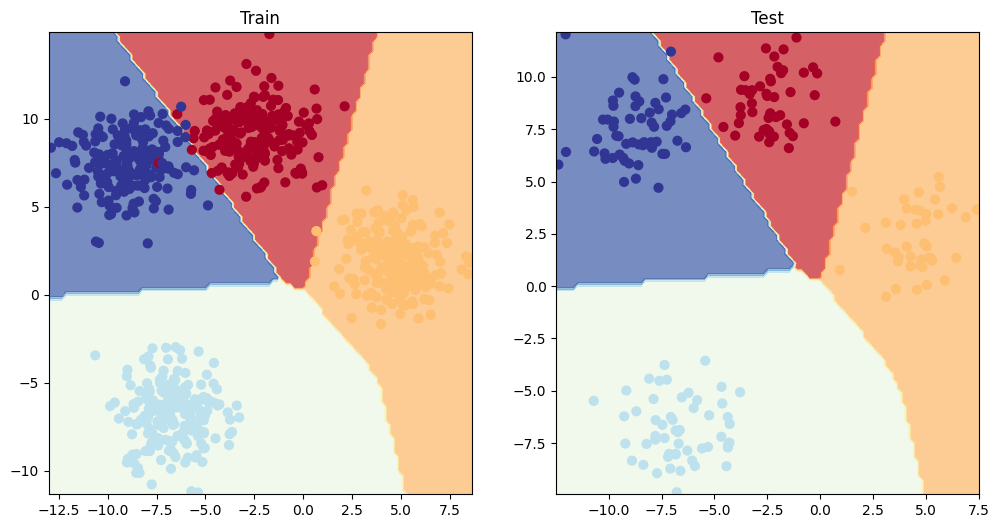

In [ ]:
# Visualizing.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## Extra classification metrics

- Accuracy => Out of 100 samples, how many does our model get right?
- Precision.
- Recall.
- F1-score.
- Confusion Matrix.
- Classification Report.
